In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols, wls

In [175]:
# Target Universe: Tech Workers in US represented in single ASEC sample
# Dependent Variable(s?) income_total, income_wages
# Independent Variables: state, region, metropolitan_area, 
# age*, education*, occupation_lastyr*, state_lastyr, whymove*
# #NOTE: adjust sample to reduce overcounting of non-head members in household?



In [176]:
raw = pd.read_csv('cps_00009.csv')

In [177]:
#

In [178]:
raw.isnull().sum(axis = 0)


YEAR              0
SERIAL            0
MONTH             0
CPSID             0
ASECFLAG          0
ASECWTH           0
REGION            0
STATEFIP          0
METAREA           0
PERNUM            0
CPSIDP            0
ASECWT            0
AGE               0
SEX               0
EMPSTAT           0
LABFORCE          0
OCC               0
CLASSWKR          0
UHRSWORKT         0
UHRSWORK1         0
EDUC              0
OCCLY             0
INDLY             0
WKXPNS       180084
INCTOT            0
INCWAGE           0
MIGSTA1           0
WHYMOVE           0
dtype: int64

In [179]:
# TO DROP: YEAR, SERIAL, MONTH, CPSID, ASECFLAG, CPSID, 
# NEW ORDER: INCTOT, INCWAGE, WKXPNS, OCC, OCCLY, REGION, METAREA, STATEFIP, MIGSTA1, AGE, UHRSWORKT, EDUC, WHYMOVE,  


In [180]:
r2016 = raw.loc[raw['YEAR']==2016]
r2017 = raw.loc[raw['YEAR']==2017]
r2018 = raw.loc[raw['YEAR']==2018]

print(raw.shape)
raw.head()

(551485, 28)


,YEAR,SERIAL,MONTH,CPSID,ASECFLAG,ASECWTH,REGION,STATEFIP,METAREA,PERNUM,...,UHRSWORKT,UHRSWORK1,EDUC,OCCLY,INDLY,WKXPNS,INCTOT,INCWAGE,MIGSTA1,WHYMOVE
0,2016,2,3,20141202933700,1,1132.05,11,23,9998,1,...,999,0,30,0,0,9999.0,13309,0,99,0
1,2016,7,3,20151202935900,1,1077.54,11,23,9998,1,...,999,0,50,0,0,9999.0,11681,0,99,0
2,2016,7,3,20151202935900,1,1077.54,11,23,9998,2,...,999,0,81,0,0,9999.0,17615,0,99,0
3,2016,8,3,20160202937400,1,1151.49,11,23,9998,1,...,999,0,81,0,0,9999.0,24099,0,99,0
4,2016,9,3,20160102910900,1,705.00,11,23,9998,1,...,999,0,73,9140,6190,1471.0,6300,6000,99,0


In [252]:
raw.columns

Index(['YEAR', 'SERIAL', 'MONTH', 'CPSID', 'ASECFLAG', 'ASECWTH', 'REGION',
       'STATEFIP', 'METAREA', 'PERNUM', 'CPSIDP', 'ASECWT', 'AGE', 'SEX',
       'EMPSTAT', 'LABFORCE', 'OCC', 'CLASSWKR', 'UHRSWORKT', 'UHRSWORK1',
       'EDUC', 'OCCLY', 'INDLY', 'WKXPNS', 'INCTOT', 'INCWAGE', 'MIGSTA1',
       'WHYMOVE'],
      dtype='object')

In [182]:
raw['MIGSTA1'].value_counts()

99    494405
0       5766
6       4474
48      3418
12      2317
91      1844
36      1524
39      1434
17      1416
13      1230
42      1213
51      1190
37      1172
26      1124
22      1110
4       1104
53      1036
25      1027
30      1026
1        946
49       927
47       917
40       890
5        888
18       874
8        854
35       852
32       828
41       802
28       786
16       784
56       770
55       767
20       743
29       730
34       704
27       682
38       673
11       668
2        645
24       641
45       639
15       627
21       603
31       591
54       588
19       556
46       515
9        464
50       456
33       349
10       346
44       320
23       230
Name: MIGSTA1, dtype: int64

In [183]:
target_cols = 'INCTOT, INCWAGE, WKXPNS, OCC, OCCLY, REGION, METAREA, STATEFIP, MIGSTA1, AGE, UHRSWORKT, EDUC, WHYMOVE, ASECWT, ASECWTH'.split(', ')


In [184]:
len(r2016.columns)

28

In [185]:
def raw_column_filter(in_df):
    
    target_cols = ['INCTOT','INCWAGE', 'WKXPNS','OCC','OCCLY','REGION', 'METAREA', 'STATEFIP', 'MIGSTA1', 'AGE',
    'UHRSWORKT','EDUC', 'WHYMOVE', 'ASECWT', 'ASECWTH']
    
    renamed_cols = ['total_income','wage_income','work_expenses','occupation','occupation_ly','region','met_area','state',
                   'state_ly','age','usual_hours_work','education','move_reason','asec_wt','asec_wt_h']
    
    out_df = in_df[target_cols]
    out_df.columns = renamed_cols  
    return out_df


def find_computer_occupations(in_df):
    #TODO: ADD OCCUPATION CODE 0110
    out_df = in_df[in_df.occupation<=1107]
    out_df = out_df[out_df.occupation>=1000]
    return out_df

def filter_0incomes_codes(in_df):
    out_df = in_df[in_df.income==0]
    return out_df
    
def create_region_dummies(in_df):
    simple_regions = in_df.region.apply(lambda x: str(x)[0]).astype('category')
    simple_regions = simple_regions.map( {'1':'north',
                                          '2': 'midwest',
                                          '3': 'south',
                                          '4': 'west'}
                                        )
    out_df = in_df
    out_df['simple_regions'] = simple_regions
    dummies = pd.get_dummies(simple_regions, prefix='dum')
    return out_df,dummies

def create_state_dummies(in_df):
    'NY','CA','TX'

#def create_
       
    

In [186]:
filteredtest=raw_column_filter(r2016)
compstest = find_computer_occupations(filteredtest)
compstest = compstest.loc[compstest['wage_income'] != 0 ]

In [187]:
filteredtest.describe()

,total_income,wage_income,work_expenses,occupation,occupation_ly,region,met_area,state,state_ly,age,usual_hours_work,education,move_reason,asec_wt,asec_wt_h
count,1.854870e+05,1.854870e+05,185487.000000,185487.000000,185487.000000,185487.000000,185487.000000,185487.000000,185487.000000,185487.00000,185487.000000,185487.000000,185487.000000,185487.000000,185487.000000
mean,2.259810e+07,2.279864e+06,5907.428887,2010.812790,2079.290015,29.554481,5957.624734,27.681929,91.285853,36.17370,589.064102,64.458749,0.751977,1719.088077,1679.426439
std,4.178702e+07,4.168169e+06,4203.054127,2743.324968,2780.838924,10.303365,3213.098093,16.283460,23.303806,22.56866,474.751516,41.048444,2.742816,1065.911059,1022.340851
min,-1.273700e+04,0.000000e+00,0.000000,0.000000,0.000000,11.000000,60.000000,1.000000,0.000000,0.00000,0.000000,1.000000,0.000000,69.880000,101.190000
25%,1.200000e+04,0.000000e+00,1779.000000,0.000000,0.000000,21.000000,3362.000000,12.000000,99.000000,16.00000,40.000000,30.000000,0.000000,846.260000,834.760000
50%,3.701400e+04,3.000000e+04,9999.000000,0.000000,0.000000,31.000000,5960.000000,28.000000,99.000000,35.00000,999.000000,73.000000,0.000000,1651.990000,1640.200000
75%,1.500000e+05,1.280000e+05,9999.000000,4140.000000,4220.000000,41.000000,9360.000000,41.000000,99.000000,54.00000,999.000000,92.000000,0.000000,2218.350000,2133.940000
max,1.000000e+08,9.999999e+06,9999.000000,9840.000000,9840.000000,42.000000,9998.000000,56.000000,99.000000,85.00000,999.000000,125.000000,19.000000,12515.280000,8148.970000


In [188]:
comptest,region_dummies=create_region_dummies(compstest)

In [189]:
comptest.head()

,total_income,wage_income,work_expenses,occupation,occupation_ly,region,met_area,state,state_ly,age,usual_hours_work,education,move_reason,asec_wt,asec_wt_h,simple_regions
314,105616,70000,1779.0,1107,1107,11,9998,23,99,52,40,111,0,1446.40,1446.40,north
360,69175,69000,1779.0,1006,1006,11,9998,23,99,57,42,111,0,1443.55,1443.55,north
400,94363,44000,1711.0,1050,1050,11,9998,23,99,58,15,111,0,1313.19,1313.19,north
439,59025,59000,1779.0,1030,1030,11,9998,23,99,42,40,111,0,985.99,985.99,north
638,16380,15000,1369.0,1050,5620,11,4290,23,99,26,64,73,0,1579.71,1579.71,north


In [190]:
comptest.met_area.value_counts()

9998    215
8840    155
5606    141
1125     69
6161     69
7365     68
7601     64
4484     62
7401     59
1605     57
1922     54
521      54
3362     40
6442     36
6201     35
5121     33
3760     32
4761     31
641      27
5921     24
7321     22
722      21
2083     21
2161     20
200      19
8280     19
6642     19
5001     18
7161     18
7040     17
       ... 
3980      1
480       1
2760      1
4881      1
6250      1
1440      1
7681      1
3621      1
5740      1
5220      1
1710      1
5170      1
1800      1
1020      1
1880      1
1010      1
9050      1
560       1
2905      1
2310      1
6961      1
6600      1
2640      1
680       1
2670      1
6800      1
1340      1
4682      1
580       1
4100      1
Name: met_area, Length: 194, dtype: int64

In [191]:
pd.get_dummies(comptest)

,total_income,wage_income,work_expenses,occupation,occupation_ly,region,met_area,state,state_ly,age,usual_hours_work,education,move_reason,asec_wt,asec_wt_h,simple_regions_midwest,simple_regions_north,simple_regions_south,simple_regions_west
314,105616,70000,1779.0,1107,1107,11,9998,23,99,52,40,111,0,1446.40,1446.40,0,1,0,0
360,69175,69000,1779.0,1006,1006,11,9998,23,99,57,42,111,0,1443.55,1443.55,0,1,0,0
400,94363,44000,1711.0,1050,1050,11,9998,23,99,58,15,111,0,1313.19,1313.19,0,1,0,0
439,59025,59000,1779.0,1030,1030,11,9998,23,99,42,40,111,0,985.99,985.99,0,1,0,0
638,16380,15000,1369.0,1050,5620,11,4290,23,99,26,64,73,0,1579.71,1579.71,0,1,0,0
759,120532,120000,1779.0,1107,1107,11,4290,23,99,45,40,123,0,572.44,572.44,0,1,0,0
1113,53008,52500,1779.0,1006,1006,11,6401,23,99,42,40,92,0,646.40,646.40,0,1,0,0
1203,78932,62000,1779.0,1105,1105,11,6401,23,99,34,40,81,0,650.44,650.44,0,1,0,0
1453,77081,65000,1779.0,1020,1020,11,9998,33,99,36,40,111,0,476.23,476.23,0,1,0,0
1620,87162,87000,1779.0,1010,1010,11,9998,33,99,48,40,111,0,384.05,384.05,0,1,0,0


In [192]:
print(len(compstest.asec_wt_h))
print(len(stage))

2223
2223


In [193]:
sampleregs=compstest.region.apply(lambda x: str(x)[0])

In [194]:
compstest['simple_regions']= sampleregs

In [195]:
compstest = compstest.loc[compstest['wage_income'] != 0 ]

In [196]:
compstest.loc[compstest['wage_income'] > 300000 ]

,total_income,wage_income,work_expenses,occupation,occupation_ly,region,met_area,state,state_ly,age,usual_hours_work,education,move_reason,asec_wt,asec_wt_h,simple_regions
7341,440000,440000,1779.0,1010,1010,11,1125,25,99,40,50,123,0,1434.14,1434.14,1
17762,400016,400000,1779.0,1010,1010,12,5606,36,99,35,40,123,0,2090.47,2090.47,1
18045,415366,400000,1779.0,1107,1107,12,5606,36,99,57,45,111,0,4266.58,4266.58,1
18649,400848,400000,1779.0,1010,1010,12,5606,36,99,43,60,123,0,2448.06,2448.06,1
39516,400209,400000,1779.0,1107,1107,21,1605,17,99,55,40,111,0,1767.93,1767.93,2
60909,1113999,1109999,1779.0,1020,1020,22,5921,31,99,37,40,123,0,646.13,646.13,2
60910,1100000,1099999,1779.0,1020,1020,22,5921,31,99,32,40,123,0,646.13,646.13,2
102830,669472,666000,1779.0,1107,430,32,9998,1,99,46,40,123,0,984.64,984.64,3
119737,604017,600000,1779.0,1106,1106,33,8560,40,99,51,50,111,0,1014.97,1014.97,3
123515,440016,440000,1779.0,1060,1010,33,1922,48,99,43,40,123,0,1991.40,1991.40,3


In [197]:
stage = pd.concat([region_dummies,compstest.wage_income],axis=1)

In [198]:
stage = stage.loc[stage['wage_income'] != 0]

11.205773339970841
0.6637028381759236


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if sys.path[0] == '':


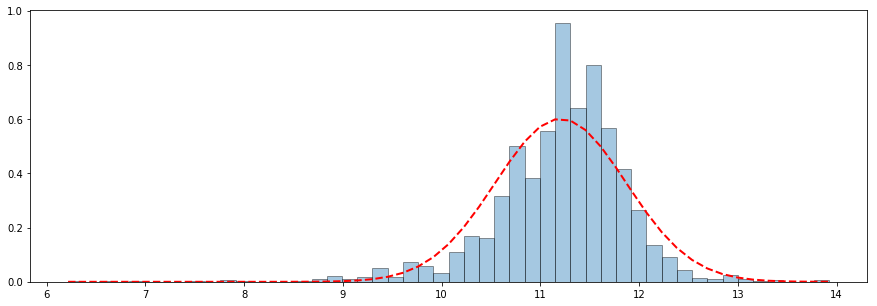

In [210]:
#normalize total income
import matplotlib.mlab as mlab
inc_norm = np.log1p(comptest['total_income'])
mu = inc_norm.mean()
print(mu)
# Standard distribution
sigma = inc_norm.std()
print(sigma)
num_bins = 50
plt.figure(figsize=(15, 5))
n, bins, patches = plt.hist(inc_norm, num_bins, normed=1, edgecolor = 'black', lw = 1,alpha = .40)
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)

In [201]:
norm_inc_regions = pd.concat([inc_norm, region_dummies], axis = 1)

In [202]:
f = 'total_income~dum_midwest+dum_north+dum_south+dum_west'
model = wls(formula=f, data=norm_inc_regions, weights=compstest.asec_wt_h).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:           total_income   R-squared:                       0.005
Model:                            WLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.475
Date:                Thu, 07 Mar 2019   Prob (F-statistic):             0.0154
Time:                        15:37:13   Log-Likelihood:                -2478.3
No. Observations:                2223   AIC:                             4965.
Df Residuals:                    2219   BIC:                             4987.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       8.9701      0.011    780.175      0.000       8.948       8.993
dum_midwest     2.1743      0.027     79.261      0.000       2.120       2.228
dum_north       2.2594      0.027     85.077      0.000       2.207       2.311
dum_south       2.2315      0.022     99.964      0.000       2.188       2.275
dum_west        2.3049      0.024     97.788      0.000       2.259       2.351
==============================================================================
Omnibus:                      703.534   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4833.604
Skew:                          -1.313   Prob(JB):                         0.00
Kurtosis:                       9.730   Cond. No.                     9.79e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.65e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [33]:
compstest.total_income.describe()

count    2.223000e+03
mean     8.911436e+04
std      6.381376e+04
min      5.000000e+02
25%      5.219000e+04
50%      7.966200e+04
75%      1.100000e+05
max      1.113999e+06
Name: total_income, dtype: float64

In [239]:
mean = compstest.total_income.mean()
std = compstest.total_income.std()
quar25, quar75 = compstest.total_income.quantile([0.25,0.75])
quar75

110000.0

In [35]:
# fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

# for i, ax in enumerate(fig.axes):
#     if i < len(features_to_analyse) - 1:
#         sns.regplot(x=features_to_analyse[i],y='SalePrice')

In [241]:
testing.head()

,total_income,wage_income,work_expenses,occupation,occupation_ly,region,met_area,state,state_ly,age,usual_hours_work,education,move_reason,asec_wt,asec_wt_h,simple_regions
314,105616,70000,1779.0,1107,1107,11,9998,23,99,52,40,111,0,1446.40,1446.40,north
360,69175,69000,1779.0,1006,1006,11,9998,23,99,57,42,111,0,1443.55,1443.55,north
400,94363,44000,1711.0,1050,1050,11,9998,23,99,58,15,111,0,1313.19,1313.19,north
439,59025,59000,1779.0,1030,1030,11,9998,23,99,42,40,111,0,985.99,985.99,north
1113,53008,52500,1779.0,1006,1006,11,6401,23,99,42,40,92,0,646.40,646.40,north


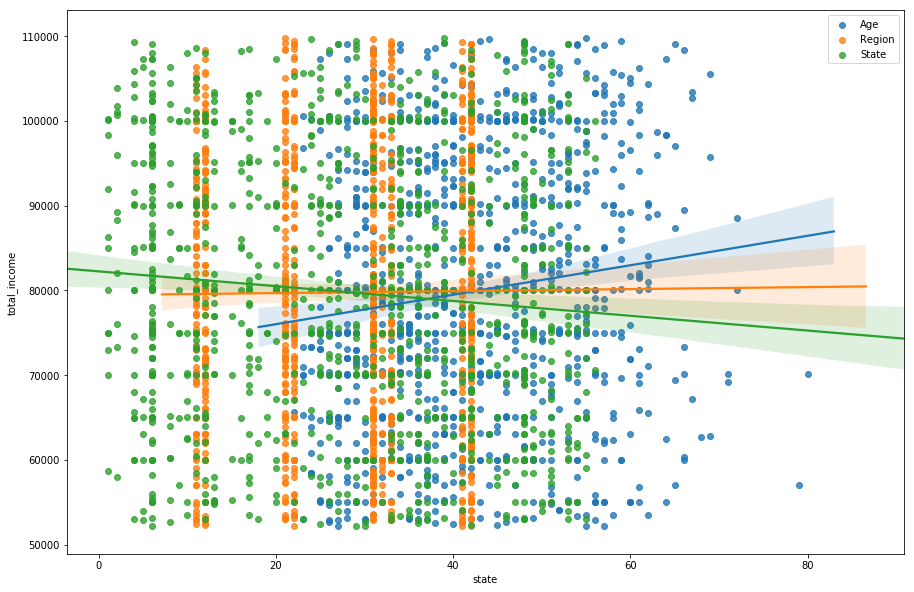

In [259]:
plt.figure(figsize = (15, 10))
testing = compstest.loc[compstest['total_income'].isin(range(int(quar25), int(quar75)))]
sns.regplot(x=testing.age,y=testing.total_income, label='Age')
sns.regplot(x=testing.region,y=testing.total_income, label = 'Region')
sns.regplot(x=testing.state,y=testing.total_income, label='State')
#sns.regplot(x=testing.education,y=testing.total_income, label='Education')
plt.legend()

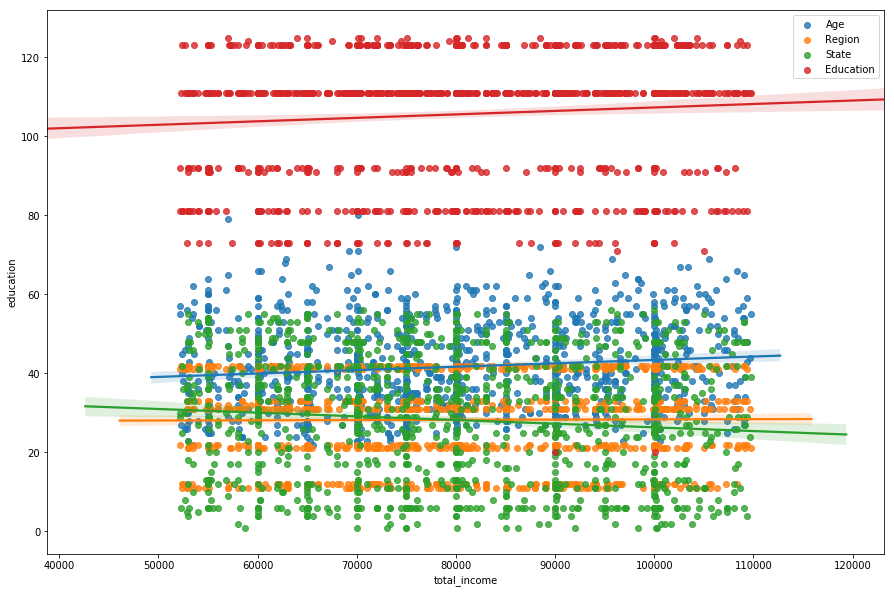

In [248]:
plt.figure(figsize = (15, 10))
testing = compstest.loc[compstest['total_income'].isin(range(int(quar25), int(quar75)))]
sns.regplot(x=testing.total_income,y=testing.age, label='Age')
sns.regplot(x=testing.total_income,y=testing.region, label = 'Region')
sns.regplot(x=testing.total_income,y=testing.state, label='State')
sns.regplot(x=testing.total_income,y=testing.education, label='Education')
plt.legend()

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

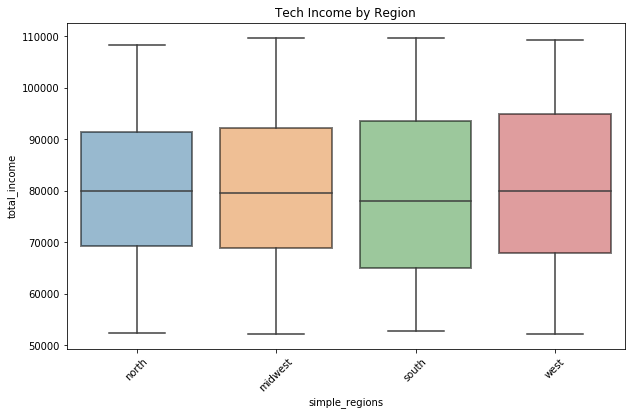

In [114]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x=comptest['simple_regions'],y=testing.total_income)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('Tech Income by Region')
plt.xticks(rotation=45)

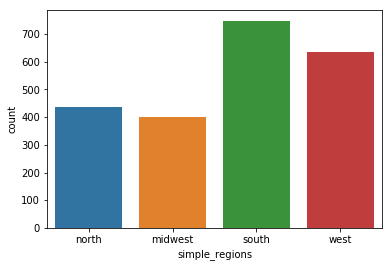

In [118]:
sns.countplot(x=comptest['simple_regions'])

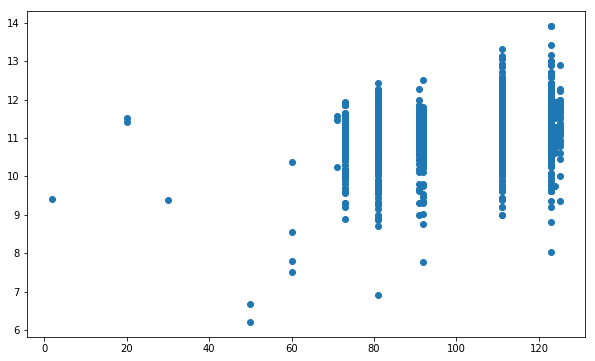

In [222]:
plt.figure(figsize = (10, 6))
plt.scatter(comptest['education'].astype('category'), inc_norm)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

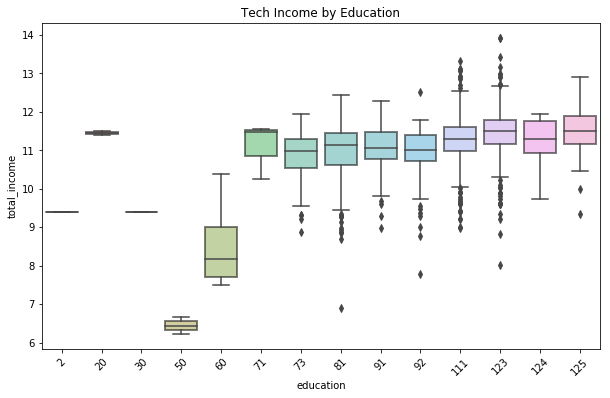

In [232]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x=comptest['education'],y=inc_norm)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('Tech Income by Education')
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 <a list of 51 Text xticklabel objects>)

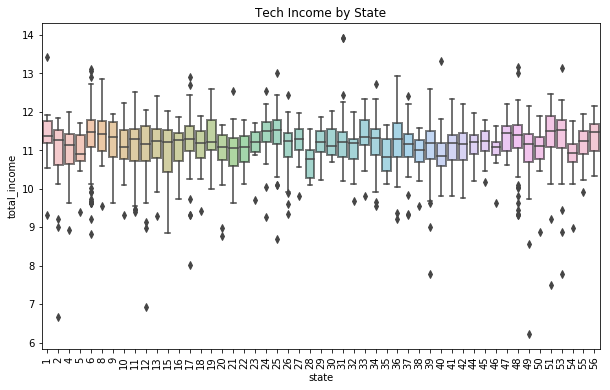

In [235]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x=comptest['state'],y=inc_norm)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('Tech Income by State')
plt.xticks(rotation=90)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

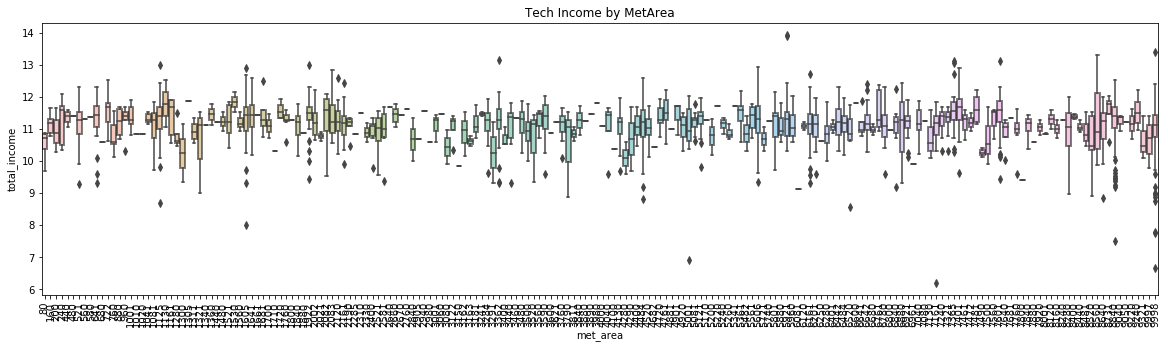

In [249]:
plt.figure(figsize = (20, 5))
ax = sns.boxplot(x=comptest['met_area'],y=inc_norm)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('Tech Income by MetArea')
plt.xticks(rotation=90)

In [106]:
# raw_filtered = raw.loc[raw['INCTOT'] != 0]
# raw_filtered = raw_filtered.loc[raw['INCTOT'] != 99999999.0]
# raw_filtered = raw_filtered.loc[raw['INCTOT'] != 99999998.0]
# raw_filtered = raw_filtered.loc[raw['AGE'] <=80]

#raw[['REGION','METAREA']]



In [8]:
# raw2016_filtered = raw.loc[raw['INCTOT'] != 0]
# raw2016_filtered = raw2016_filtered.loc[raw['INCTOT'] != 99999999.0]
# raw2016_filtered = raw2016_filtered.loc[raw['INCTOT'] != 99999998.0]
# raw2016_filtered = raw2016_filtered.loc[raw['AGE'] <=80]

In [9]:
raw_filtered.head()

,YEAR,SERIAL,MONTH,CPSID,ASECFLAG,ASECWTH,REGION,METAREA,PERNUM,CPSIDP,...,AGE,SEX,EDUC,OCCLY,INDLY,WKXPNS,INCTOT,INCWAGE,MIGSTA1,WHYMOVE
0,2016,2,3,20141202933700,1,1132.05,11,9998,1,20141202933701,...,79,2,30,0,0,9999.0,13309,0,99,0
1,2016,7,3,20151202935900,1,1077.54,11,9998,1,20151202935901,...,60,2,50,0,0,9999.0,11681,0,99,0
2,2016,7,3,20151202935900,1,1077.54,11,9998,2,20151202935902,...,59,1,81,0,0,9999.0,17615,0,99,0
3,2016,8,3,20160202937400,1,1151.49,11,9998,1,20160202937401,...,69,1,81,0,0,9999.0,24099,0,99,0
4,2016,9,3,20160102910900,1,705.00,11,9998,1,20160102910901,...,24,1,73,9140,6190,1471.0,6300,6000,99,0


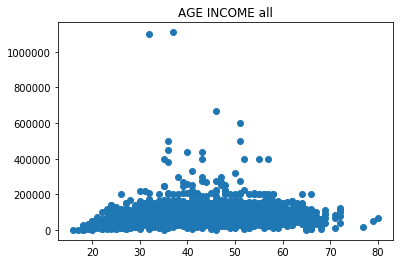

In [242]:
plt.scatter(compstest['age'], compstest['wage_income'])
plt.title('AGE INCOME all')

plt.show()
#all age income for all 3 yrs

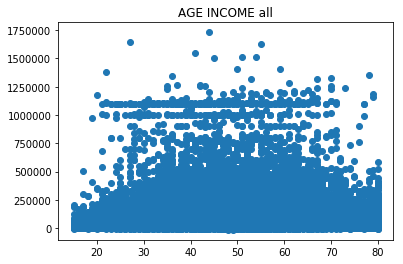

In [13]:
plt.scatter(raw2016_filtered['AGE'], raw2016_filtered['INCTOT'])
plt.title('AGE INCOME all')

plt.show()
#all age income 2016

In [192]:
def filt_metro(metarea, data):
    return data.loc[data['METAREA']==metarea]

/Users/colemiller1/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


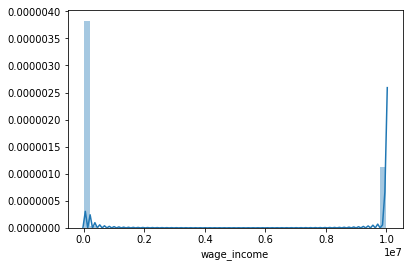

In [87]:
sns.distplot(filteredtest.wage_income) #all occupation

y=237.98074269113496x+44179.446209894944


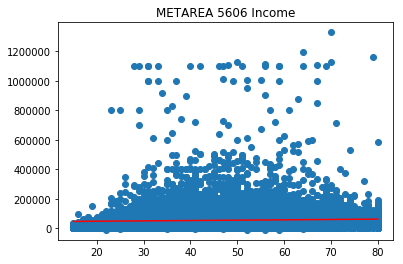

In [195]:
plt.scatter(filt_metro(5606, raw_filtered)['AGE'], filt_metro(5606, raw_filtered)['INCTOT'])
plt.title('METAREA 5606 Income')

m, b, r, p, std_err = stats.linregress(filt_metro(5606, raw_filtered)['AGE'], filt_metro(5606, raw_filtered)['INCTOT'])
x = np.linspace(15,80,100)
y = m*x+b
plt.plot(x, y, '-r')
print(f'y={m}x+{b}')

#all occupation in NYC area


In [142]:
comptest.head()

,total_income,wage_income,work_expenses,occupation,occupation_ly,region,met_area,state,state_ly,age,usual_hours_work,education,move_reason,asec_wt,asec_wt_h,simple_regions
314,105616,70000,1779.0,1107,1107,11,9998,23,99,52,40,111,0,1446.40,1446.40,north
360,69175,69000,1779.0,1006,1006,11,9998,23,99,57,42,111,0,1443.55,1443.55,north
400,94363,44000,1711.0,1050,1050,11,9998,23,99,58,15,111,0,1313.19,1313.19,north
439,59025,59000,1779.0,1030,1030,11,9998,23,99,42,40,111,0,985.99,985.99,north
638,16380,15000,1369.0,1050,5620,11,4290,23,99,26,64,73,0,1579.71,1579.71,north


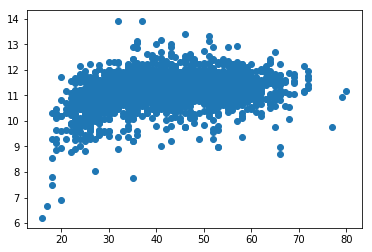

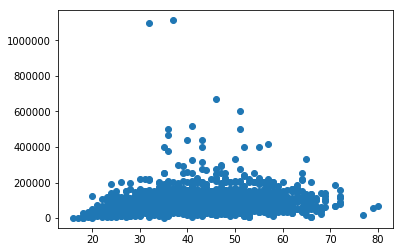

In [163]:
plt.scatter(norm_inc_age['age'], norm_inc_age['total_income'])
plt.show()
plt.scatter(comptest['age'], comptest['total_income'])
plt.show()

In [156]:
norm_inc_age = pd.concat([inc_norm, comptest['age']], axis = 1)
norm_inc_age.head()

,total_income,age
314,11.567575,52
360,11.144409,57
400,11.454915,58
439,10.985733,42
638,9.703877,26


In [164]:
f = 'total_income~age'
model = wls(formula=f, data=norm_inc_age, weigh=comptest.asec_wt).fit()
model.summary()
#NYC area all occ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:           total_income   R-squared:                       0.080
Model:                            WLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     193.5
Date:                Thu, 07 Mar 2019   Prob (F-statistic):           3.03e-42
Time:                        15:15:53   Log-Likelihood:                -2149.7
No. Observations:                2223   AIC:                             4303.
Df Residuals:                    2221   BIC:                             4315.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.5268      0.051    207.883      0.000      10.428      10.626
age            0.0165      0.001     13.912      0.000       0.014       0.019
==============================================================================
Omnibus:                      510.018   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2392.383
Skew:                          -1.018   Prob(JB):                         0.00
Kurtosis:                       7.657   Cond. No.                         160.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [141]:
f = 'wage_income~AGE'
model = ols(formula=f, data=filt_metro(5606, raw_filtered)).fit()
model.summary()
#NYC area all occ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_income   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     83.32
Date:                Thu, 07 Mar 2019   Prob (F-statistic):           1.53e-19
Time:                        14:58:58   Log-Likelihood:                -27708.
No. Observations:                2223   AIC:                         5.542e+04
Df Residuals:                    2221   BIC:                         5.543e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.527e+04   4983.837      9.083      0.000    3.55e+04     5.5e+04
age         1065.6564    116.749      9.128      0.000     836.708    1294.605
==============================================================================
Omnibus:                     2620.597   Durbin-Watson:                   1.610
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           516248.174
Skew:                           5.862   Prob(JB):                         0.00
Kurtosis:                      76.730   Cond. No.                         160.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [249]:
filt_metro(5606, raw_tech).describe()
#tech NYC area

,YEAR,SERIAL,MONTH,CPSID,ASECFLAG,ASECWTH,REGION,METAREA,PERNUM,CPSIDP,...,AGE,SEX,EDUC,OCCLY,INDLY,WKXPNS,INCTOT,INCWAGE,MIGSTA1,WHYMOVE
count,409.000000,409.000000,409.0,4.090000e+02,409.0,409.000000,409.0,409.0,409.000000,4.090000e+02,...,409.000000,409.000000,409.000000,409.000000,409.000000,292.000000,409.000000,409.000000,409.000000,409.000000
mean,2016.916870,10664.562347,3.0,1.232482e+13,1.0,2492.117995,12.0,5606.0,1.601467,1.232482e+13,...,41.156479,1.232274,109.699267,1040.877751,6886.728606,1791.232877,101330.349633,93075.652812,91.420538,0.938875
std,0.806186,1370.676910,0.0,9.841035e+12,0.0,882.904832,0.0,0.0,0.904833,9.841035e+12,...,12.222807,0.422800,15.633361,38.097974,1547.207436,312.213097,67826.404184,64146.149916,20.936860,2.865221
min,2016.000000,7756.000000,3.0,0.000000e+00,1.0,1463.120000,12.0,5606.0,1.000000,0.000000e+00,...,17.000000,1.000000,20.000000,1005.000000,570.000000,171.000000,500.000000,0.000000,9.000000,0.000000
25%,2016.000000,9484.000000,3.0,0.000000e+00,1.0,1880.020000,12.0,5606.0,1.000000,0.000000e+00,...,32.000000,1.000000,111.000000,1010.000000,6870.000000,1779.000000,60000.000000,55000.000000,99.000000,0.000000
50%,2017.000000,10970.000000,3.0,2.015120e+13,1.0,2176.710000,12.0,5606.0,1.000000,2.015120e+13,...,40.000000,1.000000,111.000000,1020.000000,7380.000000,1779.000000,86000.000000,80000.000000,99.000000,0.000000
75%,2018.000000,11897.000000,3.0,2.017010e+13,1.0,2815.050000,12.0,5606.0,2.000000,2.017010e+13,...,50.000000,1.000000,123.000000,1050.000000,7380.000000,2000.000000,126101.000000,120000.000000,99.000000,0.000000
max,2018.000000,12819.000000,3.0,2.018030e+13,1.0,5982.980000,12.0,5606.0,7.000000,2.018030e+13,...,80.000000,2.000000,125.000000,1107.000000,9590.000000,2000.000000,415366.000000,410000.000000,99.000000,17.000000


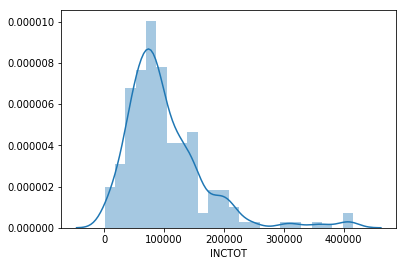

In [252]:
sns.distplot(filt_metro(5606, raw_tech)['INCTOT'])
#tech nyc 

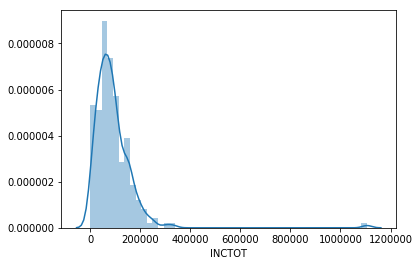

In [253]:
sns.distplot(filt_metro(4484, raw_tech)['INCTOT'])
#tech LA

In [202]:
raw_filtered.describe()

,YEAR,SERIAL,MONTH,CPSID,ASECFLAG,ASECWTH,REGION,METAREA,PERNUM,CPSIDP,...,AGE,SEX,EDUC,OCCLY,INDLY,WKXPNS,INCTOT,INCWAGE,MIGSTA1,WHYMOVE
count,366506.000000,366506.000000,366506.0,3.665060e+05,366506.0,366506.000000,366506.000000,366506.000000,366506.000000,3.665060e+05,...,366506.000000,366506.000000,366506.000000,366506.000000,366506.000000,246225.000000,3.665060e+05,3.665060e+05,366506.000000,366506.000000
mean,2016.993574,47907.225077,3.0,1.360366e+13,1.0,1784.821819,29.388015,5944.418498,1.715792,1.360366e+13,...,46.056968,1.507869,86.362810,3118.177206,4726.790475,3899.193798,4.653386e+04,3.606962e+04,92.634882,0.722073
std,0.814096,27478.220978,0.0,9.446463e+12,0.0,1091.203584,10.352502,3217.220791,1.003194,9.446463e+12,...,17.094314,0.499939,24.418379,2889.925265,3608.591704,3671.408067,6.590772e+04,6.195771e+04,20.858423,2.702351
min,2016.000000,2.000000,3.0,0.000000e+00,1.0,93.240000,11.000000,60.000000,1.000000,0.000000e+00,...,15.000000,1.000000,2.000000,0.000000,0.000000,0.000000,-1.645800e+04,0.000000e+00,1.000000,0.000000
25%,2016.000000,23797.000000,3.0,0.000000e+00,1.0,871.647500,21.000000,3291.000000,1.000000,0.000000e+00,...,32.000000,1.000000,73.000000,0.000000,0.000000,1779.000000,1.406000e+04,0.000000e+00,99.000000,0.000000
50%,2017.000000,48054.000000,3.0,2.016010e+13,1.0,1705.440000,31.000000,5960.000000,1.000000,2.016010e+13,...,45.000000,2.000000,81.000000,3060.000000,6070.000000,2000.000000,3.020500e+04,2.200000e+04,99.000000,0.000000
75%,2018.000000,72277.000000,3.0,2.017011e+13,1.0,2340.540000,41.000000,9240.000000,2.000000,2.017011e+13,...,59.000000,2.000000,111.000000,4965.000000,7970.000000,9999.000000,5.817000e+04,5.000000e+04,99.000000,0.000000
max,2018.000000,95006.000000,3.0,2.018031e+13,1.0,9027.360000,42.000000,9998.000000,16.000000,2.018031e+13,...,80.000000,2.000000,125.000000,9840.000000,9890.000000,9999.000000,1.731899e+06,1.609999e+06,99.000000,19.000000


In [233]:
def var_frame(var, data):
    new = pd.concat([data['YEAR'],data[var],data['INCTOT']], ignore_index=True,axis=1)  
    new.columns = ['YEAR',var, 'INCTOT']
    return new

In [234]:
var_frame('EDUC', raw_filtered)

,YEAR,EDUC,INCTOT
0,2016,30,13309
1,2016,50,11681
2,2016,81,17615
3,2016,81,24099
4,2016,73,6300
6,2016,73,8796
8,2016,81,17786
9,2016,30,4561
10,2016,30,12841
11,2016,50,19930


In [244]:
def plotting(var, data):
    plt.scatter(data[var], data['INCTOT'])
    plt.show()
    sns.distplot(data[var])
    return plt.show()

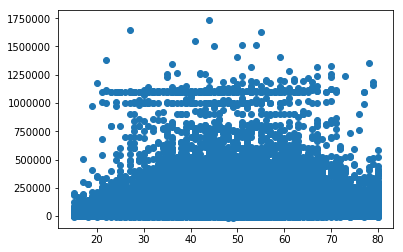

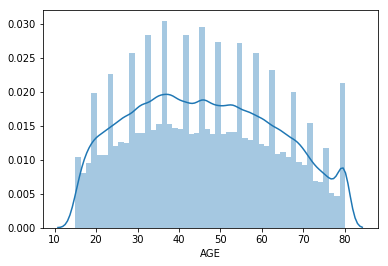

In [245]:
plotting('AGE', raw_filtered)

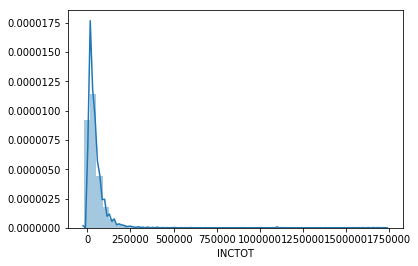

In [262]:
sns.distplot(raw_filtered['INCTOT'])

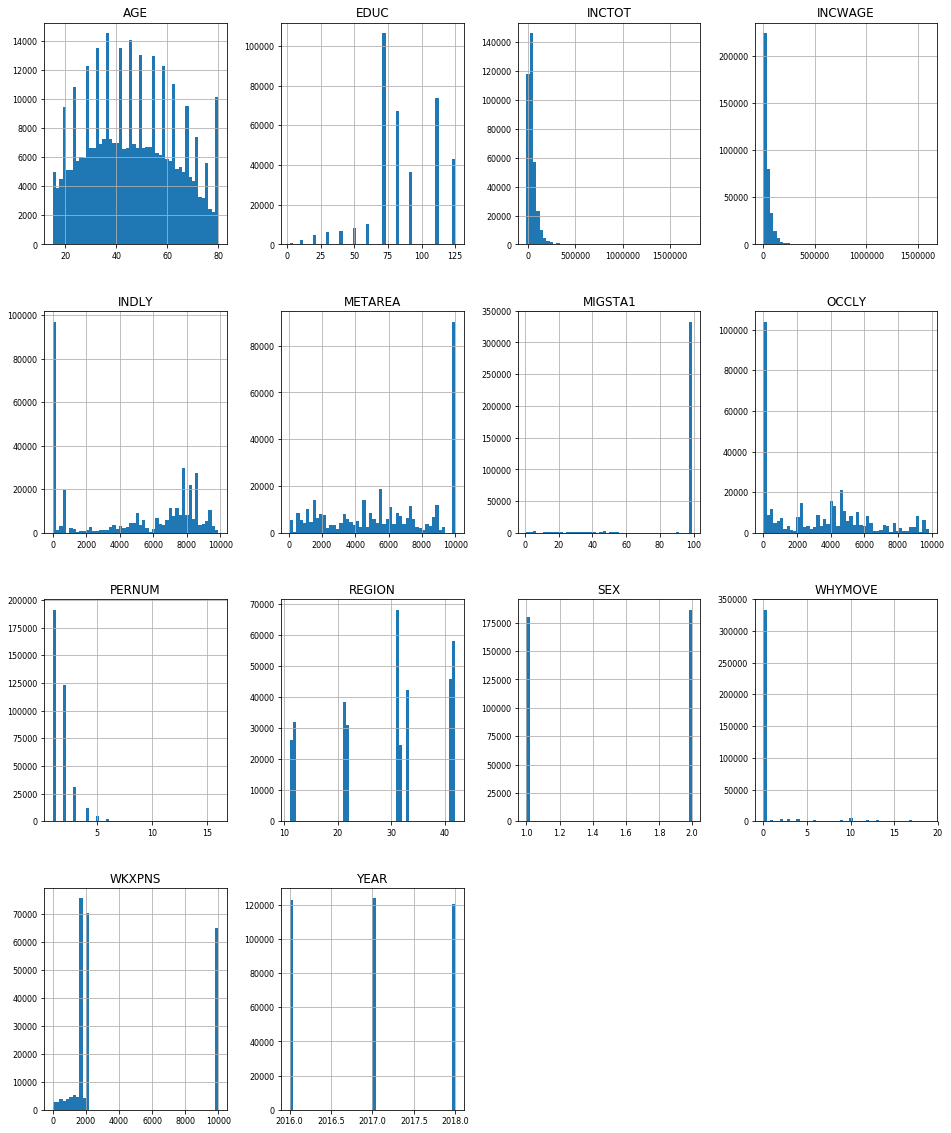

In [261]:
overview = raw_filtered.drop(['ASECFLAG', 'SERIAL', 'CPSID', 'ASECWT', 'ASECWTH', 'CPSIDP', 'MONTH', 'SERIAL'], axis =1)

overview.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);


In [263]:
overview.corr()

,YEAR,REGION,METAREA,PERNUM,AGE,SEX,EDUC,OCCLY,INDLY,WKXPNS,INCTOT,INCWAGE,MIGSTA1,WHYMOVE
YEAR,1.000000,0.005367,-0.004366,0.002214,0.013943,0.000148,0.014556,-0.005368,-0.003442,0.020629,0.021626,0.014953,0.012116,-0.009332
REGION,0.005367,1.000000,0.114869,0.023690,-0.014183,-0.011351,-0.048228,0.009988,-0.010409,0.003281,-0.016688,-0.015832,-0.035103,0.018764
METAREA,-0.004366,0.114869,1.000000,-0.006567,0.027359,-0.003048,-0.053704,0.013330,-0.042955,0.025148,-0.034787,-0.041681,0.003176,-0.004113
PERNUM,0.002214,0.023690,-0.006567,1.000000,-0.289129,0.010242,-0.168227,0.087067,0.028102,0.007381,-0.121965,-0.085382,-0.001545,0.004288
AGE,0.013943,-0.014183,0.027359,-0.289129,1.000000,0.023593,0.033600,-0.294151,-0.328852,0.345768,0.068532,-0.050270,0.161212,-0.133460
SEX,0.000148,-0.011351,-0.003048,0.010242,0.023593,1.000000,0.046191,-0.168242,0.085775,0.090879,-0.164871,-0.141549,0.000320,-0.001604
EDUC,0.014556,-0.048228,-0.053704,-0.168227,0.033600,0.046191,1.000000,-0.175233,0.227699,-0.191168,0.308683,0.282274,-0.011222,0.005335
OCCLY,-0.005368,0.009988,0.013330,0.087067,-0.294151,-0.168242,-0.175233,1.000000,0.344970,-0.599373,-0.016071,0.062739,-0.047035,0.032610
INDLY,-0.003442,-0.010409,-0.042955,0.028102,-0.328852,0.085775,0.227699,0.344970,1.000000,-0.723731,0.163331,0.243955,-0.059481,0.040914
WKXPNS,0.020629,0.003281,0.025148,0.007381,0.345768,0.090879,-0.191168,-0.599373,-0.723731,1.000000,-0.228806,-0.322162,0.068222,-0.046066


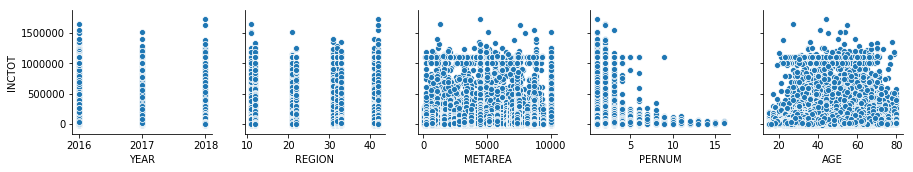

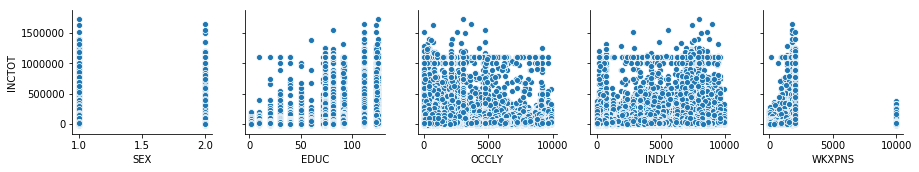

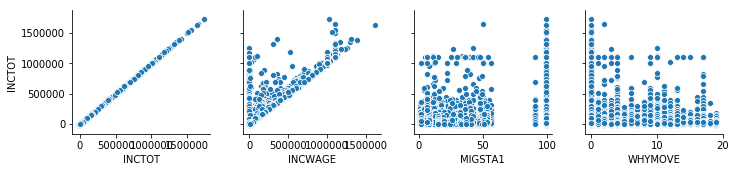

In [264]:
for i in range(0, len(overview.columns), 5):
    sns.pairplot(data=overview,
                x_vars=overview.columns[i:i+5],
                y_vars=['INCTOT'])

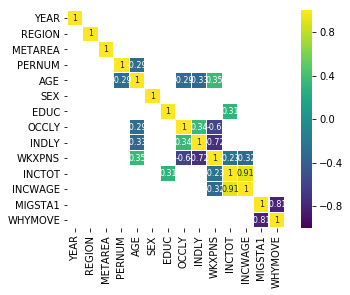

In [272]:
corr = overview.corr()
sns.heatmap(corr[(corr >= 0.3) | (corr <= -0.2)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [ ]:
features_to_analyse = [x for x in quantitative_features_list if x in golden_features_list]